## Importing Necessary Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'font.size': 15})
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import re
import scipy.stats as stats
import pandas_profiling
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.feature_selection import f_regression
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Importing Input Datasets

In [4]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1. Predicting Credit Card Spend & Identifying Key Drivers/Data Set.xlsx')

## Data Inspection

In [5]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,...,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,...,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,...,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,...,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,...,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,...,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0


In [ ]:
data.shape

(5000, 130)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
region,5000.0,3.001400,1.421760,1.0,2.0,3.0,4.0,5.0
townsize,4998.0,2.687275,1.425925,1.0,1.0,3.0,4.0,5.0
gender,5000.0,0.503600,0.500037,0.0,0.0,1.0,1.0,1.0
age,5000.0,47.025600,17.770338,18.0,31.0,47.0,62.0,79.0
agecat,5000.0,4.238800,1.308785,2.0,3.0,4.0,5.0,6.0
...,...,...,...,...,...,...,...,...
ownfax,5000.0,0.178800,0.383223,0.0,0.0,0.0,0.0,1.0
news,5000.0,0.472600,0.499299,0.0,0.0,0.0,1.0,1.0
response_01,5000.0,0.083600,0.276815,0.0,0.0,0.0,0.0,1.0
response_02,5000.0,0.129800,0.336117,0.0,0.0,0.0,0.0,1.0


## Data Pre-Processing

'custid' is insignificant due to high cardinality and 'birthmonth' is also irrelevant in explaining any variance in the dependent variable so we are going to drop them.

In [6]:
data.drop(columns= ['custid', 'birthmonth'], inplace= True)

There are 13 log transformed derived variables of pre existing variables so they are just unnecessary and needs to be dropped also.

In [7]:
list_ln = []
for i in range(len(data.columns)):
  z = re.match("ln", data.columns[i], re.I)
  if z!=None:
    list_ln.append(z.string)

In [8]:
print(list_ln)

['lninc', 'lncreddebt', 'lnothdebt', 'lnlongmon', 'lnlongten', 'lntollmon', 'lntollten', 'lnequipmon', 'lnequipten', 'lncardmon', 'lncardten', 'lnwiremon', 'lnwireten']


In [9]:
data.drop(columns= list_ln, inplace=True)

### Derived Variable Creation

The data contains two dependent variable - 'cardspent' and 'card2spent'.

In [ ]:
data[['cardspent', 'card2spent']].head()

,cardspent,card2spent
0,81.66,67.80
1,42.60,34.94
2,184.22,175.75
3,340.99,18.42
4,255.10,252.73


Combining both of the dependent variable into one - 'total_card_spent' and also dropping them.

In [10]:
data['total_card_spent'] = data.cardspent + data.card2spent

In [11]:
data.drop(columns=['cardspent', 'card2spent'], inplace=True)

### Variable creation using Variable Transformation

Checking distribution of the dpendent variable

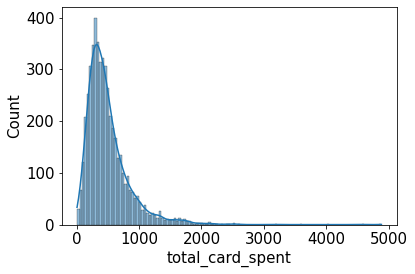

In [14]:
sns.histplot(data.total_card_spent, kde=True)
plt.show()

It is not following the normal distribution and is positively skewed. So due to the parametric nature of statistical model that the dependent variable is assumed to be normally distributed, 'total_card_spent' needs to be transformed.

Trying Log Transformation

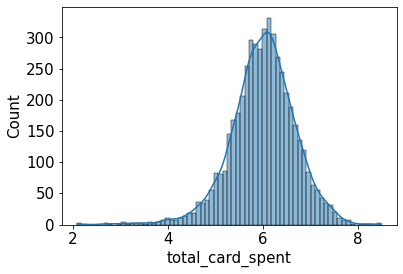

In [15]:
sns.histplot(np.log(data.total_card_spent), kde=True)
plt.show()

The variable does become more normally distributed with a log transformation, so we will be proceeding with it.

In [16]:
data['ln_total_spent'] = np.log(data.total_card_spent)

In [17]:
data.drop(columns=['total_card_spent'], inplace=True)

### Exploratory Data Analysis

#### Correlation Matrix

In [18]:
corr_matrix = data.corr()
corr_matrix

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,empcat,retire,income,inccat,debtinc,creddebt,othdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,...,tenure,churn,longmon,longten,tollfree,tollmon,tollten,equip,equipmon,equipten,callcard,cardmon,cardten,wireless,wiremon,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,ln_total_spent
region,1.000000,0.414194,-0.012810,-0.026525,-0.018455,0.013173,0.015710,-0.004717,-0.013768,-0.011036,-0.009345,-0.042849,0.044823,0.041850,-0.005480,0.017427,0.040081,-0.006856,0.015631,0.056498,0.052842,0.050299,0.048203,-0.012093,-0.020351,0.022667,0.002627,-0.010965,0.024290,0.022076,-0.020726,0.045620,0.017052,-0.004867,-0.000842,0.017012,0.016652,0.008766,0.040264,0.031004,...,0.005008,-0.002515,0.009256,0.004774,0.013429,0.009225,0.006177,0.023631,0.027443,0.015505,0.024336,0.018543,0.019498,0.031453,0.028090,0.018854,0.021835,0.022923,0.018778,0.019668,0.023290,0.019332,0.026085,0.028630,0.009908,0.032778,0.007721,0.022061,0.011319,0.048589,0.040228,0.020596,0.007504,0.026391,0.036622,0.012312,-0.013004,0.005899,0.005694,0.037273
townsize,0.414194,1.000000,0.009491,-0.075464,-0.069081,0.002531,0.003685,-0.010860,-0.019810,-0.059014,-0.058169,-0.065906,-0.001915,-0.007592,-0.019592,-0.018986,-0.005378,0.023590,-0.031194,0.029925,0.026110,0.023250,0.045430,-0.000221,-0.018997,0.031730,-0.011035,0.012033,0.002267,0.022970,-0.006583,0.024069,-0.003137,-0.042229,-0.043306,0.003666,0.015417,-0.009573,0.002204,0.000974,...,-0.029885,0.000838,-0.014821,-0.019304,0.000660,-0.016720,-0.021664,-0.006345,0.000903,-0.007701,-0.024730,-0.014204,-0.012821,0.007911,0.004476,-0.006593,0.004593,-0.006882,-0.004059,0.003048,-0.004100,-0.010576,0.002855,0.003592,-0.008314,0.026502,-0.000383,-0.004527,0.016431,0.020692,0.022758,0.002664,0.005331,0.007896,-0.000636,-0.028678,-0.006225,-0.010037,-0.007200,0.009190
gender,-0.012810,0.009491,1.000000,-0.010186,-0.007427,-0.000643,-0.002673,-0.016470,0.000311,-0.010946,-0.013842,-0.021040,-0.009952,-0.002149,0.005309,-0.012172,-0.017953,-0.001620,0.001782,0.003888,0.002013,-0.001918,0.031949,0.027684,0.014869,-0.012092,0.025103,0.006139,0.008747,0.002267,0.023061,0.006351,0.003200,-0.014109,-0.006030,0.014120,0.009135,0.013086,-0.007475,-0.002408,...,-0.009456,-0.013391,-0.028278,-0.026560,-0.010862,-0.019203,-0.012676,0.011702,0.003851,-0.004435,-0.012769,-0.021602,-0.016510,-0.006170,-0.019312,-0.015518,-0.019839,-0.006053,-0.011541,-0.012861,-0.039693,-0.024920,-0.017734,-0.018902,0.020335,-0.000600,-0.004655,-0.003570,0.012181,-0.002861,-0.001116,-0.006963,-0.021319,0.001164,0.009167,-0.020837,0.018058,0.001385,-0.009685,-0.078351
age,-0.026525,-0.075464,-0.010186,1.000000,0.969879,-0.094560,-0.081129,0.037709,0.011206,0.703053,0.739573,0.567519,0.189301,0.209659,0.039084,0.119633,0.137583,-0.394208,0.416807,0.003031,-0.002892,-0.003425,-0.336149,0.027098,0.015496,0.014604,-0.016220,0.008047,0.003430,-0.001318,0.023293,-0.018264,-0.022519,0.822341,0.827064,-0.008960,-0.081563,0.010315,0.175766,0.141003,...,0.612030,-0.265976,0.444227,0.474560,-0.002612,0.109114,0.262278,-0.141550,-0.101777,0.093005,0.286721,0.287552,0.442786,-0.080747,-0.021753,0.109004,0.238136,-0.077833,-0.074501,-0.126458,-0.018343,0.001570,-0.002783,0.002204,-0.120078,-0.075824,-0.027446,0.099194,0.093029,0.055100,-0.074423,-0.133284,-0.217524,-0.235226,-0.042090,0.365204,0.015140,0.013175,-0.026231,0.002318
agecat,-0.018455,-0.069081,-0.007427,0.969879,1.000000,-0.079021,-0.064124,0.032554,0.004465,0.676722,0.732246,0.511335,0.211927,0.249394,0.041339,0.131001,0.156817,-0.392859,0.422564,0.004785,0.000480,0.000824,-0.329221,0.028180,0.021223,0.013147,-0.011077,0.013894,0.0

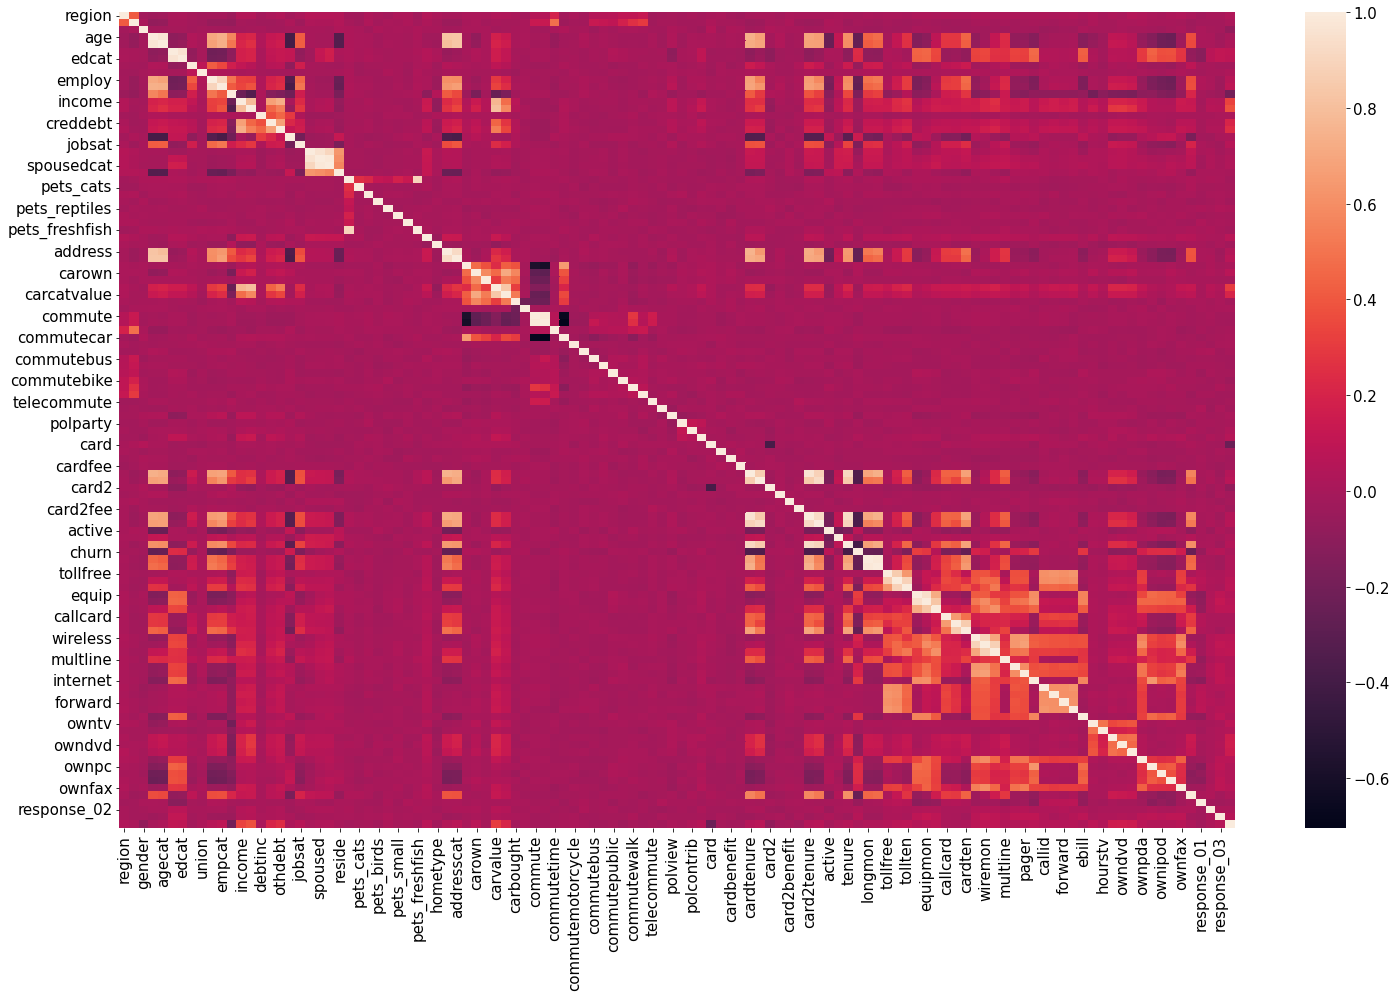

In [21]:
plt.figure(figsize=(25,15))
sns.heatmap(corr_matrix)

In [ ]:
#corr_matrix.to_csv('Corr_matrix.csv')

#### Pandas Profiling

This is a Large dataset due to high number of variables so a default profile report will generate a large html file.
To avoid that we are going to be generating a minimalised version of the report using a custom config file.

In [ ]:
#report_minimal = pandas_profiling.ProfileReport(df=data, config_file='/content/drive/MyDrive/Colab Notebooks/config_minimal.yaml' )

In [ ]:
#report_minimal.to_file('ProfileReportMinimal.html')

In [ ]:
#report_minimal

Dropping insignificant and multi-correlated variables from the analysis of Profile report generated via pandas profiling and correlation matrix.

In [ ]:
corr_matrix[['ln_total_spent']].loc[['cardtenure', 'cardtenurecat', 'card2tenure', 'card2tenurecat', 'tenure'], :]

,ln_total_spent
cardtenure,0.050404
cardtenurecat,0.071112
card2tenure,0.054090
card2tenurecat,0.064626
tenure,0.050648


In [22]:
list_drop = ['agecat', 'edcat','marital', 'spousedcat', 'address', 'commute', 'longmon', 'equip', 'cardtenure', 'card2tenure', 'card2tenurecat', 'tenure']

Explaination:
1. 'agecat', 'edcat', 'spousedcat' because these are the derived variables from pre existing variables only.
2. 'marital' as the same information explained by this variable can also be explained through 'spoused'.
3. 'address' and 'commute' can be better explained via their derived variables which are 'addresscat' and 'commutecat', respectively.


In [23]:
data.drop(columns=list_drop, inplace=True)

#### Checking for Duplicate Values

In [ ]:
data.duplicated().sum()

0

#### Separating Numerical and Categorical variables

In [24]:
cat_cols = ['region', 'townsize', 'gender', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'inccat', 
           'default', 'jobsat', 'homeown', 'hometype', 'addresscat', 'cars', 'carown', 'cartype', 
           'carcatvalue', 'carbought', 'carbuy', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 
           'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 
           'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenurecat', 
           'card2', 'card2type', 'card2benefit', 'card2fee', 'active', 'bfast', 'churn', 'tollfree', 
           'callcard', 'wireless', 'multline', 'voice', 'pager', 'internet', 'callid', 'callwait', 'forward', 'confer',
           'ebill', 'owntv', 'ownvcr', 'owndvd', 'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news', 'response_01', 
           'response_02', 'response_03']

In [25]:
num_cols = []
for x in data.columns:
  if x not in cat_cols:
    num_cols.append(x)

print(num_cols)

['age', 'ed', 'income', 'debtinc', 'creddebt', 'othdebt', 'spoused', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime', 'longten', 'tollmon', 'tollten', 'equipmon', 'equipten', 'cardmon', 'cardten', 'wiremon', 'wireten', 'hourstv', 'ln_total_spent']


UDF to get Data Audit Report for Continuous Variables

In [ ]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

UDF to get a Data Audit Report for Categorical Variables

In [ ]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

#### Data Audit Report for Continuous Variables

In [ ]:
data[num_cols].apply(lambda x: continuous_var_summary(x)).round(2)

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,ln_total_spent
N,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,4998.00,4997.00,5000.00,5000.00,5000.00,5000.00,5000.00,4998.00,5000.00,5000.00,5000.00,5000.00
NMISS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,3.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00
SUM,235128.00,72715.00,273798.00,49770.80,9286.63,18272.30,30564.00,11020.00,15337.00,2502.00,1962.00,552.00,278.00,573.00,233.00,9237.00,116162.90,126677.00,3542232.15,66322.25,2889162.55,64956.55,2350882.00,77219.25,3600951.00,53505.95,2109923.05,98225.00,30006.22
MEAN,47.03,14.54,54.76,9.95,1.86,3.65,6.11,2.20,3.07,0.50,0.39,0.11,0.06,0.11,0.05,1.85,23.23,25.35,708.87,13.26,577.83,12.99,470.18,15.44,720.48,10.70,421.98,19.64,6.00
MEDIAN,47.00,14.00,38.00,8.80,0.93,2.10,-1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.00,25.00,350.00,0.00,0.00,0.00,0.00,13.75,425.00,0.00,0.00,20.00,6.03
STD,17.77,3.28,55.38,6.40,3.42,5.40,7.74,1.39,3.41,0.86,0.80,0.49,0.33,0.57,0.47,3.07,21.23,5.88,979.29,16.31,949.15,19.21,912.22,15.01,922.23,19.80,1001.00,5.17,0.67
VAR,315.78,10.77,3066.67,40.96,11.67,29.11,59.96,1.94,11.66,0.74,0.63,0.24,0.11,0.32,0.22,9.45,450.78,34.56,959011.00,266.02,900888.73,369.14,832146.47,225.23,850499.92,392.03,1002007.58,26.68,0.45
MIN,18.00,6.00,9.00,0.00,0.00,0.00,-1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,8.00,0.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.09
P1,18.00,8.00,9.00,0.70,0.03,0.11,-1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,13.00,2.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.06
P5,20.00,9.00,13.00,1.90,0.10,0.29,-1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,16.00,12.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,4.89


#### Data Audit Report for Categorical Variables

In [ ]:
data[cat_cols].apply(lambda x: categorical_var_summary(x)).round(2)

,region,townsize,gender,jobcat,union,employ,empcat,retire,inccat,default,jobsat,homeown,hometype,addresscat,cars,carown,cartype,carcatvalue,carbought,carbuy,commutecat,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,active,bfast,churn,tollfree,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
N,5000.00,4998.00,5000.00,5000.0,5000.00,5000.00,5000.0,5000.00,5000.00,5000.00,5000.0,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.0,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.0,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.0,5000.00,5000.00,5000.00,5000.0,5000.00,5000.0,5000.00,5000.0,5000.00,5000.00,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
NMISS,0.00,2.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MODE,5.00,1.00,1.00,2.0,0.00,0.00,2.0,0.00,2.00,0.00,3.0,1.00,1.0,3.00,2.00,1.00,0.00,1.00,0.00,0.0,1.0,1.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,9.00,4.00,0.00,0.00,1.0,4.00,4.0,3.00,0.00,5.00,3.00,4.00,4.00,0.00,0.0,3.0,0.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,1.0,1.00,1.00,1.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FREQ,1027.00,1436.00,2518.00,1640.0,4244.00,659.00,1180.0,4262.00,1797.00,3829.00,1085.0,3148.00,2265.0,1221.00,1607.00,3704.00,2287.00,2399.00,2901.00,3195.0,2905.0,3395.0,4487.00,3641.00,2970.0,3627.00,4523.00,4383.00,3081.00,4708.00,4060.0,4052.00,1733.00,3093.00,3808.00,2590.0,1344.00,1260.0,1274.00,4051.00,2351.00,1384.00,1319.00,1294.00,4064.00,2670.0,1875.0,3734.00,2622.00,3581.00,3656.00,2558.00,3485.0,3782.00,2498.00,2624.00,2605.0,2597.00,2610.0,3257.00,4915.0,4578.00,4568.00,4664.00,3995.0,3164.00,2604.00,2626.00,4106.00,2637.00,4582.00,4351.00,4487.00
PERCENT,20.54,28.73,50.36,32.8,84.88,13.18,23.6,85.24,35.94,76.58,21.7,62.96,45.3,24.42,32.14,74.08,45.74,47.98,58.02,63.9,58.1,67.9,89.74,72.82,59.4,72.54,90.46,87.66,61.62,94.16,81.2,81.04,34.66,61.86,76.16,51.8,26.88,25.2,25.48,81.02,47.02,27.68,26.38,25.88,81.28,53.4,37.5,74.68,52.44,71.62,73.12,51.16,69.7,75.64,49.96,52.48,52.1,51.94,52.2,65.14,98.3,91.56,91.36,93.28,79.9,63.28,52.08,52.52,82.12,52.74,91.64,87.02,89.74


### Handling Continuous Variables

#### Outliers Treatment

UDF to get Outliers Summmary:

In [ ]:
def outliers_summ(data,method='percentile',x=(0.01,0.99)):
    ''' Gives Outliers Summary (Count) of a DataFrame
        data = DataFrame
        method = 'percentile': 0.01th and 0.99th percentile
                'iqr' : Inter Quartile Method
                :'percentile' by default
        x = In tuple format
                :to further modify the percentile in
                 'percentile' method, default=(0.01,0.99)'''
    
    outliers_count = pd.DataFrame()
    Feature_Name = []
    Outliers_Count = []
    Percentage = []

    for i in data.columns:
        if method == 'percentile':
            upper=data[i].quantile(x[1])
            lower=data[i].quantile(x[0])
        else:
            q1=data[i].quantile(0.25)
            q3=data[i].quantile(0.75)
            iqr=q3-q1
            upper=q3+1.5*iqr
            lower=q1-1.5*iqr
        Feature_Name.append(i)
        Outliers_Count.append(sum(data[i]>upper)+sum(data[i]<lower))
        Percentage.append(((sum(data[i]>upper)+sum(data[i]<lower))/data[i].size)*100)
    
    outliers_count = pd.concat([outliers_count,pd.Series(Feature_Name),pd.Series(Outliers_Count),pd.Series(Percentage)],axis=1)
    outliers_count.columns = ['Feature_Name','Outliers_Count','Percentage']
    outliers_count.sort_values(by='Outliers_Count',ascending=False, ignore_index=True,inplace=True)
    outliers_count.loc[len(outliers_count.index)]=['TOTAL',outliers_count.Outliers_Count.sum(),(outliers_count.Outliers_Count.sum()/data.size)*100]
    outliers_count.Percentage= outliers_count.Percentage.apply(lambda x:'{:.2f}%'.format(x))
    
    return outliers_count

In [ ]:
outliers_summ(data = data, method='percentile', x=(0.01, 0.99))

,Feature_Name,Outliers_Count,Percentage
0,ln_total_spent,100,2.00%
1,creddebt,100,2.00%
2,othdebt,100,2.00%
3,longten,99,1.98%
4,debtinc,93,1.86%
...,...,...,...
98,commutepublic,0,0.00%
99,commuterail,0,0.00%
100,commutebus,0,0.00%
101,polparty,0,0.00%


Capping at 99th and 1st percentile.

In [26]:
data[num_cols] = data[num_cols].apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.dropna().quantile(0.99)))

#### Missing Value Treatment

In [ ]:
data[num_cols].isna().sum()

age               0
ed                0
income            0
debtinc           0
creddebt          0
othdebt           0
spoused           0
reside            0
pets              0
pets_cats         0
pets_dogs         0
pets_birds        0
pets_reptiles     0
pets_small        0
pets_saltfish     0
pets_freshfish    0
carvalue          0
commutetime       2
longten           3
tollmon           0
tollten           0
equipmon          0
equipten          0
cardmon           0
cardten           2
wiremon           0
wireten           0
hourstv           0
ln_total_spent    0
dtype: int64

Amount of missing values are low, so we are just going to impute the with mean.

In [27]:
Imputer_Cont = SimpleImputer(strategy='mean')

In [28]:
data[num_cols] = pd.DataFrame(Imputer_Cont.fit_transform(data[num_cols]))

In [ ]:
data[num_cols].head()

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,ln_total_spent
0,20.0,15.0,31.0,11.1,1.200909,2.240091,-1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.3,22.0,34.40,29.0,161.05,29.50,126.1,14.25,60.0,0.00,0.00,13.0,5.007029
1,22.0,17.0,15.0,18.6,1.222020,1.567980,-1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.8,29.0,330.60,0.0,0.00,54.85,1975.0,16.00,610.0,45.65,1683.55,18.0,4.350794
2,67.0,14.0,35.0,9.9,0.928620,2.536380,13.0,3.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,18.8,24.0,1858.35,0.0,0.00,0.00,0.0,23.00,1410.0,0.00,0.00,21.0,5.886021
3,23.0,16.0,20.0,5.7,0.033160,1.117200,18.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7,38.0,199.45,0.0,0.00,0.00,0.0,21.00,685.0,0.00,0.00,26.0,5.884464
4,26.0,16.0,23.0,1.7,0.214659,0.176341,13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,32.0,74.10,16.5,387.70,0.00,0.0,17.25,360.0,19.05,410.80,27.0,6.230147


### Handling Categorical Variables

#### Missing Value Treatment

In [ ]:
data[cat_cols].isna().sum()

region         0
townsize       2
gender         0
jobcat         0
union          0
              ..
ownfax         0
news           0
response_01    0
response_02    0
response_03    0
Length: 73, dtype: int64

In [ ]:
data[cat_cols].isna().sum().sum()

2

Amount of missing values are low, so we are just going to impute the with mode as these are categorical variables.

In [29]:
Imputer_Cat = SimpleImputer(strategy='most_frequent')

In [30]:
data[cat_cols] = pd.DataFrame(Imputer_Cat.fit_transform(data[cat_cols]))

In [ ]:
data[cat_cols].head()

,region,townsize,gender,jobcat,union,employ,empcat,retire,inccat,default,jobsat,homeown,hometype,addresscat,cars,carown,cartype,carcatvalue,carbought,carbuy,commutecat,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,active,bfast,churn,tollfree,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,6.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,2.0,5.0,3.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5.0,5.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,9.0,4.0,1.0,0.0,0.0,2.0,4.0,1.0,0.0,2.0,4.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,3.0,4.0,1.0,2.0,0.0,16.0,5.0,0.0,2.0,0.0,4.0,1.0,1.0,5.0,3.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,2.0,1.0,4.0,0.0,5.0,4.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,2.0,1.0,4.0,0.0,2.0,3.0,2.0,4.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.0,4.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,3.0,1.0,3.0,2.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Creating Dummy Variables of the Nominal Categorical Variables

List of all the nominal categorical variables (except the binary variables).

In [31]:
nominal_cols = ['region', 'townsize', 'empcat', 'inccat', 'jobsat', 'hometype', 'addresscat', 'carown', 'carbought', 'carbuy', 'commutecat',
                'reason', 'polview', 'card', 'cardtype', 'cardbenefit', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'bfast', 'internet']

In [32]:
data[nominal_cols] = data[nominal_cols].apply(lambda x: x.astype('int64'))

In [33]:
OHEnc = OneHotEncoder(sparse=False, drop='first')

In [34]:
OH_cols = pd.DataFrame(OHEnc.fit_transform(data[nominal_cols]),columns = OHEnc.get_feature_names_out())

In [ ]:
OH_cols.head()

,region_2,region_3,region_4,region_5,townsize_2,townsize_3,townsize_4,townsize_5,empcat_2,empcat_3,empcat_4,empcat_5,inccat_2,inccat_3,inccat_4,inccat_5,jobsat_2,jobsat_3,jobsat_4,jobsat_5,hometype_2,hometype_3,hometype_4,addresscat_2,addresscat_3,addresscat_4,addresscat_5,carown_0,carown_1,carbought_0,carbought_1,carbuy_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
OH_cols.shape

(5000, 76)

In [35]:
data.drop(columns=nominal_cols, inplace=True)

Merging Numerical and the Dummy Variables

In [36]:
final_data = pd.concat([data, OH_cols], axis=1)

In [ ]:
final_data.head()

,gender,age,ed,jobcat,union,employ,retire,income,debtinc,creddebt,othdebt,default,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,cars,cartype,carvalue,carcatvalue,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,polparty,polcontrib,...,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1.0,20.0,15.0,1.0,1.0,0.0,0.0,31.0,11.1,1.200909,2.240091,1.0,-1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,14.3,1.0,22.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,22.0,17.0,2.0,0.0,0.0,0.0,15.0,18.6,1.222020,1.567980,1.0,-1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,1.0,6.8,1.0,29.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,67.0,14.0,2.0,0.0,16.0,0.0,35.0,9.9,0.928620,2.536380,0.0,13.0,3.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,18.8,1.0,24.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,23.0,16.0,2.0,0.0,0.0,0.0,20.0,5.7,0.033160,1.117200,1.0,18.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,8.7,1.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,26.0,16.0,2.0,0.0,1.0,0.0,23.0,1.7,0.214659,0.176341,0.0,13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,10.6,1.0,32.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
final_data.shape

(5000, 156)

### Splitting the Data into train and test

In [37]:
train, test = train_test_split(final_data, test_size=0.3, random_state=12345)

In [38]:
print('Train :',train.shape)
print('Test :',test.shape)

Train : (3500, 156)
Test : (1500, 156)


### Feature selection based on importance using F - Regression

In [ ]:
features = train[train.columns.difference(['ln_total_spent'])]
target = train.ln_total_spent
F_values, p_values  = f_regression(features, target )

In [ ]:
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results.P_Value = pd.to_numeric(f_reg_results.P_Value)
f_reg_results.head()

,Variable,F_Value,P_Value
0,active,0.055073,0.814
1,addresscat_2,6.667207,0.010
2,addresscat_3,2.961704,0.085
3,addresscat_4,12.469536,0.000
4,addresscat_5,0.995718,0.318


Filtering out the features which are insignificant at 90% confidence interval

In [ ]:
f_reg_results_final = f_reg_results[f_reg_results.P_Value <= 0.1]
f_reg_results_final.head()

,Variable,F_Value,P_Value
1,addresscat_2,6.667207,0.010
2,addresscat_3,2.961704,0.085
3,addresscat_4,12.469536,0.000
7,bfast_3,6.095860,0.014
9,callid,16.127029,0.000


If p - values are less, then variables are siginificant in the regression equation.

In [ ]:
f_reg_vars = list(f_reg_results_final.Variable)

####  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

High VIF of an independent variable means information in that variable has already been explained by other independent variables present in the data.

In [ ]:
model_param = 'ln_total_spent ~ ' + ' + '.join(f_reg_vars)

In [ ]:
y, X = dmatrices(model_param, train, return_type = 'dataframe')

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
vif_final = vif.sort_values(by = 'VIF_Factor', ascending  = False)[vif.VIF_Factor<=4]
vif_final.head()

,Features,VIF_Factor
48,inccat_3,3.554724
32,debtinc,2.888549
57,longten,2.717860
31,creddebt,2.652680
80,retire,2.624029


In [ ]:
vif_vars = list(vif_final.Features)

In [ ]:
print(vif_vars)

['inccat_3', 'debtinc', 'longten', 'creddebt', 'retire', 'cardtenurecat_5', 'inccat_2', 'cardten', 'card2_4', 'hometype_2', 'pager', 'confer', 'card_4', 'callwait', 'card2_3', 'homeown', 'forward', 'callid', 'voice', 'cars', 'card2_2', 'card_3', 'card_2', 'commutecar', 'ed', 'ebill', 'owntv', 'ownfax', 'reason_9', 'ownpda', 'empcat_4', 'multline', 'ownpc', 'ownvcr', 'reason_2', 'owndvd', 'addresscat_3', 'owncd', 'jobsat_5', 'addresscat_2', 'news', 'owngame', 'ownipod', 'internet_4', 'card2_5', 'addresscat_4', 'hourstv', 'jobsat_4', 'cardtenurecat_2', 'churn', 'commutecat_3', 'jobsat_3', 'card_5', 'internet_3', 'reason_4', 'hometype_3', 'spoused', 'hometype_4', 'polview_6', 'commuterail', 'bfast_3', 'vote', 'polview_3', 'response_03', 'response_02', 'region_5', 'gender', 'polcontrib', 'cardbenefit_3', 'card2benefit_3', 'cardtype_3']


## DATA MODELLING
#### using Statistical Models

### Model 1 (OLS)

In [ ]:
model_param = 'ln_total_spent ~' + ' + '.join(vif_vars)

In [ ]:
lm1 = smf.ols(model_param, train).fit()

In [ ]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spent   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     23.09
Date:                Sun, 26 Dec 2021   Prob (F-statistic):          4.97e-236
Time:                        20:31:50   Log-Likelihood:                -2750.3
No. Observations:                3500   AIC:                             5645.
Df Residuals:                    3428   BIC:                             6088.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.4019      0.107     

Analysis : There are so many insignificant variables present in the data according to the t-statistics, Which might be the cause of high condition number. Also, this model is only able to explain around 30% of the variance in the dependent variable. So, we will remove the insignificant variables in the next iteration of the model.

Filtering out the insignificant variables according to the 95% Confidence Interval ( p > 0.05)

In [ ]:
lm1_summary_df = lm1.summary2().tables[1]
lm1_summary_df.loc[lm1_summary_df['P>|t|'] > 0.05, ['P>|t|']].head()

,P>|t|
longten,0.065044
cardtenurecat_5,0.070541
inccat_2,0.142845
cardten,0.769614
hometype_2,0.689360


In [ ]:
significant_vars_lm1 = list(lm1_summary_df.loc[lm1_summary_df['P>|t|'] <= 0.05, ['P>|t|']].index)
significant_vars_lm1.remove('Intercept')
print(significant_vars_lm1)

['inccat_3', 'debtinc', 'creddebt', 'retire', 'card2_4', 'card_4', 'card2_3', 'card2_2', 'card_3', 'card_2', 'reason_9', 'reason_2', 'owndvd', 'owncd', 'card2_5', 'card_5', 'region_5', 'gender', 'card2benefit_3']


### Model 2 (OLS)

In [40]:
model_param = 'ln_total_spent ~' + ' + '.join(significant_vars_lm1)

In [41]:
lm2 = smf.ols(model_param, train).fit()

In [42]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spent   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     81.57
Date:                Thu, 30 Dec 2021   Prob (F-statistic):          5.86e-261
Time:                        22:06:34   Log-Likelihood:                -2789.5
No. Observations:                3500   AIC:                             5619.
Df Residuals:                    3480   BIC:                             5742.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.5634      0.061    107.

Analysis: All the remaining variables are significant at 95% CI and even though we were able to reduce Multi-Colinearity and so thus the condition number, The model did not improved in explaining the variance in the dependent variable via the independent ones.
  This problem is complex and it requires much sofisticated methods than ols statistical model.

In [43]:
train['total_spent'] = np.exp(train.ln_total_spent)
test['total_spent'] = np.exp(test.ln_total_spent)

In [44]:
train['pred_total_spent'] = np.exp(lm2.predict(train))

In [45]:
test['pred_total_spent'] = np.exp(lm2.predict(test))

In [46]:
train[['total_spent', 'pred_total_spent']].head()

,total_spent,pred_total_spent
509,848.91,670.151862
3847,613.91,491.073340
3417,525.95,339.415502
382,331.38,322.715511
1345,848.60,339.236132


In [47]:
test[['total_spent', 'pred_total_spent']].head()

,total_spent,pred_total_spent
3183,335.15,277.664471
1071,655.48,326.579411
2640,344.38,415.199168
2282,410.72,328.722410
1595,832.93,465.111621


### Model Validation for Prediction

1. Using MAPE( Mean Absolute Percentage Error)

In [48]:
print('MAPE of Training Data :', mean_absolute_percentage_error(train.total_spent, train.pred_total_spent), ' | ',
      'MAPE of Testing Data :', mean_absolute_percentage_error(test.total_spent, test.pred_total_spent) )

MAPE of Training Data : 0.48511829492061304  |  MAPE of Testing Data : 0.5101297185668384


2. Using Root Mean Squared Error

In [49]:
print('RMSE of Training Data :', np.sqrt(mean_squared_error(train.total_spent, train.pred_total_spent)), ' | ',
      'RMSE of Testing Data :', np.sqrt(mean_squared_error(test.total_spent, test.pred_total_spent)))

RMSE of Training Data : 278.37430811537536  |  RMSE of Testing Data : 278.1776919597147


## Model Validation and Evaluation

### Decile Analysis

In [ ]:

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_total_spent'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_total_spent'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_total_spent']
Actual_avg = train[['Deciles', 'total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['total_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_total_spent']
Actual_avg = test[['Deciles', 'total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['total_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
#Decile_analysis_train.to_csv('Decile_analysis_train.csv')
#Decile_analysis_test.to_csv('Decile_analysis_test.csv')

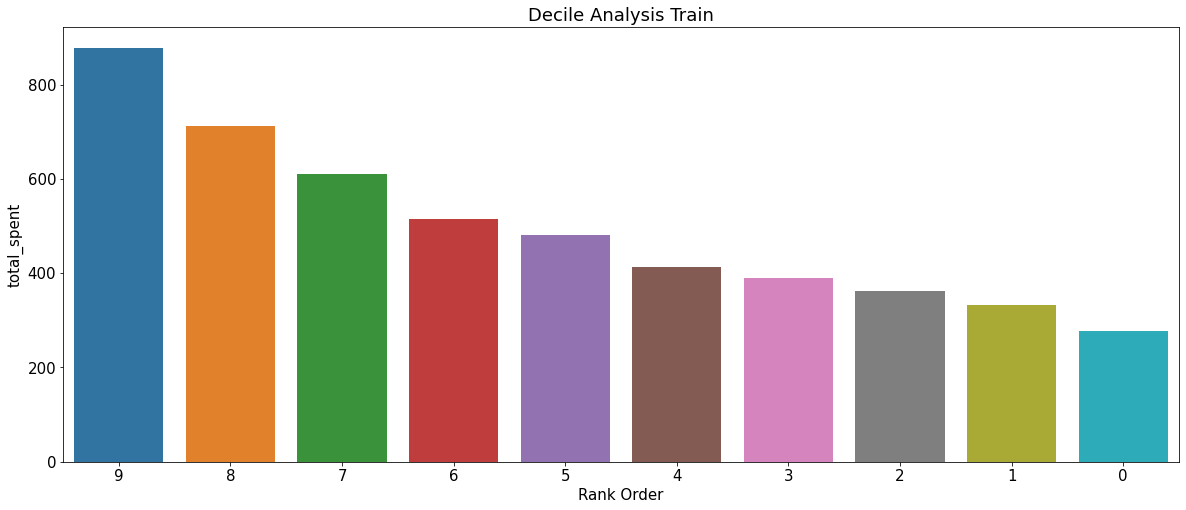

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data = Decile_analysis_train, x='Deciles', y='total_spent', order=Decile_analysis_train.sort_values(by='Deciles', ascending=False).Deciles)
plt.xlabel('Rank Order')
plt.title('Decile Analysis Train')
plt.show()

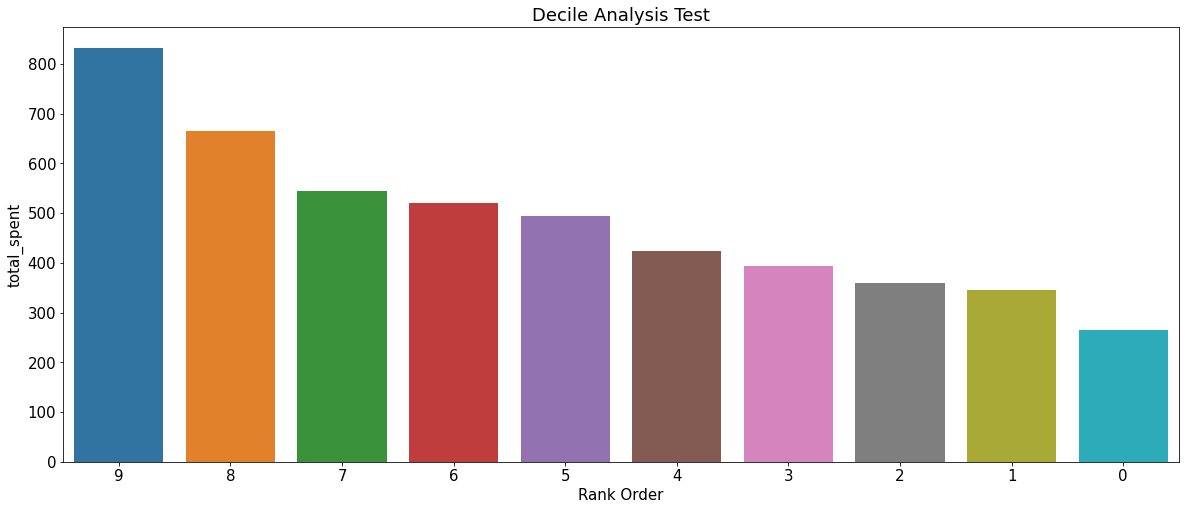

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data = Decile_analysis_test, x='Deciles', y='total_spent', order=Decile_analysis_test.sort_values(by='Deciles', ascending=False).Deciles)
plt.xlabel('Rank Order')
plt.title('Decile Analysis Test')
plt.show()

Rank Order is maintained in both train and test data as we can clearly see a staircase effect in the barplots, So the model passes the Decile Analysis Test.

But the model still performed poorly, Let's go through the assumptions as Linear Model (ols) is a highly parametric model.

### Validating the poor model performance due to LM assumptions

#### Assumption 1a : Normality of the residuals/error (using distplot)

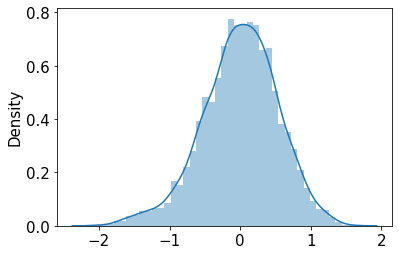

In [ ]:
sns.distplot(lm2.resid)
plt.show()

Distribution of the residuals are pretty normal.

#### Assumption 1b : Normality of the residuals/error (using Q-Q plot)

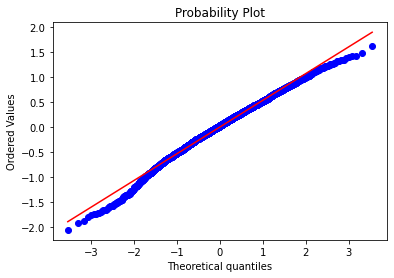

In [ ]:
from scipy import stats
import pylab

stats.probplot(lm2.resid, dist = 'norm', plot = pylab)
pylab.show()

Influencial observations can be seen at both ends deviating away from the straight line. These are caused by presence of extreme values in the data hinting towards the possibilities of having multiple segments in the data. This might be the reason of poor model performance as we are trying to predict the response for different segments with the same model.

#### Assumption 2 : Mean of residuals/errors is zero

In [ ]:
print('Mean of Residuals :',lm2.resid.mean())

Mean of Residuals : 2.7490390916032734e-15


Mean of residuals are almost zero.

#### Assumption 3 : Residuals/errors of the model should not be correlated with dependant (Y) variable

In [ ]:
print(stats.stats.pearsonr(lm2.resid, train.pred_total_spent))

(-0.00809827232851623, 0.6319834696780836)


Residuals are not correlated with the predicted variable. 

#### Assumption 4 : Homoscedasticity of residuals/errors

The spread of the residuals is quite equal along the variability of Predicted value, which tells us that the resiudals follows Homoscedasticity.

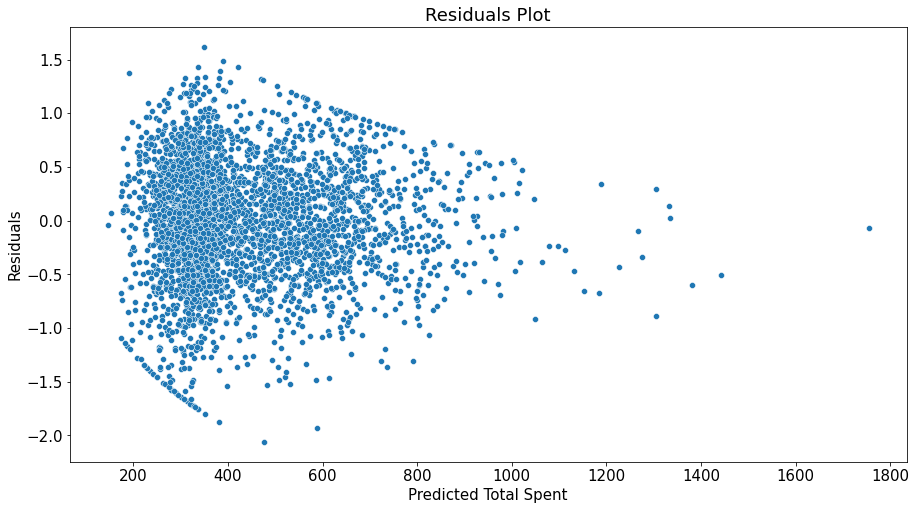

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = train.pred_total_spent, y = lm2.resid)
plt.xlabel('Predicted Total Spent')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

Residuals doesn't have equal variance along the variability of the predicted dependent variable which indicates us about residuals following Heteroscedasticity.

## Identifying Main Drivers for Spend using RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [ ]:
Features = final_data[final_data.columns.difference(['ln_total_spent'])]
Target = final_data.ln_total_spent

In [ ]:
rf_reg = RandomForestRegressor(random_state=12345)

In [ ]:
rfe = RFE(estimator=rf_reg, n_features_to_select=10)

In [ ]:
rfe = rfe.fit(Features, Target)

In [ ]:
print('Main Drivers for Credit Card Spend are : %s' % list(Features.columns[rfe.support_]))

Main Drivers for Credit Card Spend are : ['age', 'cardmon', 'carvalue', 'commutetime', 'creddebt', 'debtinc', 'income', 'longmon', 'longten', 'othdebt']


### Top 10 Important Variables:


1.   age - Age in years
2.   cardmon - Calling card last month
3.   carvalue - Primary vehicle sticker price
4.   commutetime - Commute time in minutes
5.   creddebt - Credit card debt in thousands
6.   debtinc - Debt to income ratio (x100)
7.   income - Household income in thousands
8.   longmon - Long distance last month
9.   longten - Long distance over tenure
10.  othdebt - Other debt in thousands

